# Prepare for monomer predictions of predicted dimers, then collect predictions

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob, iglob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [4]:
design_list = []
dimer_lists = [
    '06_alphafold_two_state/05_run_2_af2/predicted_dimers.list',
    '06_alphafold_two_state/05_run_2_des/predicted_dimers.list',
    '06_alphafold_two_state/05_run_3_af2/predicted_dimers.list',
    '06_alphafold_two_state/05_run_3_des/predicted_dimers.list'
]
for dimer_list in dimer_lists:
    with open(dimer_list, 'r') as f:
        design_list += [line.rstrip() for line in f]

In [7]:
print(design_list[0])

/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/af2_decoys/2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007.pdb


In [2]:
def add2silent( tag, pose, sfd_out, filename ):

    struct = sfd_out.create_SilentStructOP()
    struct.fill_struct( pose, tag )
    sfd_out.add_structure( struct )
    sfd_out.write_silent_struct( struct, filename )

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100"
}})

In [8]:
silent_filename = "06_alphafold_two_state/05_run_23_monomers/dimer-predicted_monomers.silent"
sfd_out = pyrosetta.rosetta.core.io.silent.SilentFileData( silent_filename, False, False, "binary", pyrosetta.rosetta.core.io.silent.SilentFileOptions())

for file in tqdm(design_list):
    full_pose = pyrosetta.pose_from_pdb(file)
    tag = file.split('/')[-1][:-4]
    monomer_A, monomer_B, dimer_A, dimer_B = full_pose.split_by_chain()
    add2silent(tag + '_A', monomer_A, sfd_out, silent_filename)
    add2silent(tag + '_B', monomer_B, sfd_out, silent_filename)

100%|██████████| 54/54 [03:08<00:00,  3.50s/it]


Run AF2 monomer prediction on the state X monomers of the designs predicted to dimerize.

ran the following commands:

cd ~/projects/crispy_shify/projects/crispy_shifty_dimers/06_alphafold_two_state/05_run_23_monomers

conda activate /home/nrbennet/miniconda3/envs/ampere

/home/nrbennet/software/nates_local_tools/interfaceaf2create -prefix predict_monomers -script /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/06_alphafold_two_state/monomerAF2predict.py -silent dimer-predicted_monomers.silent -args " -batch 1" -gres gpu:rtx2080:1 -conda /mnt/home/nrbennet/miniconda3/envs/ampere -structs_per_job 100


collected outputs with:

cat predict_monomers_runs/*/out.silent > af2_predictions.silent

/home/nrbennet/software/bin/fast_merge_scorefiles predict_monomers_runs 

In [2]:
scores_df = pd.read_csv(
    '06_alphafold_two_state/05_run_23_monomers/predict_monomers_runs_combined.sc',
    sep=' ',
    index_col='description',
    usecols=list(range(1,5)))
scores_df

,plddt,rmsd,time
description,,,
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_A_af2pred,90.964,1.917,223.473
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_B_af2pred,94.073,0.830,10.926
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_A_af2pred,87.393,1.745,11.026
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_B_af2pred,93.733,0.912,10.898
bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_A_af2pred,90.084,1.707,10.947
...,...,...,...
4b24843fc643e27add4f8c76b56eeb5f828683cf59f91212_B_af2pred,91.982,4.777,17.533
79f60e7df22dccb99eb514253045382e8af7bb94e871d4ea_A_af2pred,90.900,4.228,17.547
79f60e7df22dccb99eb514253045382e8af7bb94e871d4ea_B_af2pred,92.297,1.327,17.535


2it [00:00, 12.04it/s]


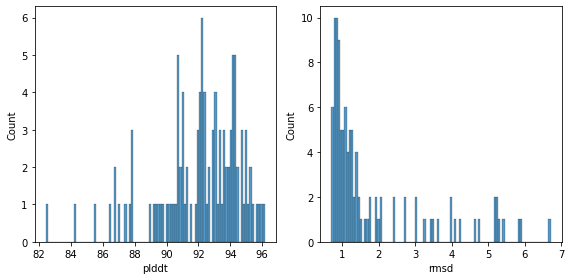

In [5]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "plddt",
        "rmsd"
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

# pairplot these as well

In [3]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

# def remove_singlets(df):
#     from copy import deepcopy
#     only_pairs_df = deepcopy(df)
#     for index in df.index:
#         if '_A_' in index:
#             if index.replace('_A_', '_B_', 1) not in df.index:
#                 only_pairs_df.drop(index, inplace=True)
#         elif '_B_' in index:
#             if index.replace('_B_', '_A_', 1) not in df.index:
#                 only_pairs_df.drop(index, inplace=True)

#     print(len(only_pairs_df))

#     return only_pairs_df

def remove_singlets(df):
    only_pairs_df = df
    for index in df.index:
        if '_A_' in index:
            if index.replace('_A_', '_B_', 1) not in df.index:
                only_pairs_df = only_pairs_df.drop(index)
        elif '_B_' in index:
            if index.replace('_B_', '_A_', 1) not in df.index:
                only_pairs_df = only_pairs_df.drop(index)

    print(len(only_pairs_df))

    return only_pairs_df

In [4]:
# Filter designs

cutoffs = [
    ('plddt', 85, 1),
    ('rmsd', 3, 0)
]

filtered_df = filter_df(scores_df, cutoffs)
filtered_df = remove_singlets(filtered_df)
filtered_df

85
64


,plddt,rmsd,time
description,,,
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_A_af2pred,90.964,1.917,223.473
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_B_af2pred,94.073,0.830,10.926
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_A_af2pred,87.393,1.745,11.026
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_B_af2pred,93.733,0.912,10.898
bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_A_af2pred,90.084,1.707,10.947
...,...,...,...
ca78c30abb2048b3ec1597b0b01a8a3a6034d637a33548e9_B_af2pred,92.091,1.443,10.235
dcf682293eecaf62ccf6aab599902a085743d38ca7c2dffb_A_af2pred,93.700,0.932,10.258
dcf682293eecaf62ccf6aab599902a085743d38ca7c2dffb_B_af2pred,92.306,1.274,10.299


In [8]:
print(f"echo \"{' '.join(filtered_df.index)}\" | silentextractspecific ../af2_predictions.silent")

echo "2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_A_af2pred 2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007_B_af2pred 95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_A_af2pred 95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0_B_af2pred bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_A_af2pred bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef_B_af2pred 03d724605623c4d0d5047b13eda8677ec5d84c7a542f7c21_A_af2pred 03d724605623c4d0d5047b13eda8677ec5d84c7a542f7c21_B_af2pred 612e355023747c73c83c270643ae624baaee4a4d5ab2b5b5_A_af2pred 7c4719e839ddece8c50e157c72e750b2378c5ce59839051f_B_af2pred 88b3ee4df312f18141e3e0acdd6bfee746919bb0a2e49e4c_A_af2pred 88b3ee4df312f18141e3e0acdd6bfee746919bb0a2e49e4c_B_af2pred a06f5b66c3d59cb31905dd9025e38d5f76037dd95202cfd6_A_af2pred a06f5b66c3d59cb31905dd9025e38d5f76037dd95202cfd6_B_af2pred f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f_A_af2pred f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f_B_af2pred fd33f41915ceee09df616b7d6eae037a8397b6ccbe052285_A

### Copy and add scores to the designs which are predicted to dimerize when together and are predicted to fold correctly as monomers ###

In [5]:
# Load design scores dataframe

output_files = ['05_two_state/run_2/af2_scores.json',
                '05_two_state/run_2/design_scores.json',
                '05_two_state/run_3/af2_scores.json',
                '05_two_state/run_3/design_scores.json']

frames = []
for output_file in output_files:
    frames.append(pd.read_json(output_file))
des_scores_df = pd.concat(frames)

des_scores_df.loc[:, 'msd_input_model'] = np.where(des_scores_df.index.str.contains('af2_decoys'), 'af2', 'rosetta')
des_scores_df.loc[:, 'int_upweight'] = np.where(des_scores_df.index.str.contains('run_3'), 3.0, None)

# save the paths to the Rosetta multistate design files, but change the dataframe indexing to only contain the uuid for matching with other dataframes later
des_scores_df['design_path'] = des_scores_df.index
des_scores_df.rename(index=lambda i: i.split('/')[-1][:-4], inplace=True)

des_scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y,msd_input_model,int_upweight,design_path
8ba6779f39e900d7c38b33cdcb8be61d2416185606595e39,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,6,0.280639,1.358968,0.261648,5.000000,0.101865,0.145690,af2,None,05_two_state/run_2/af2_decoys/8ba6779f39e900d7...
17b5f018f103054bf70b69383803a9a6c4cb8d5639f6f669,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.000000,469.840790,695.218018,...,2,0.280550,0.493832,0.181797,0.402981,0.113158,0.206446,af2,None,05_two_state/run_2/af2_decoys/17b5f018f103054b...
d4edb8d485a7e3c5fe818d12b57da4e8a3c4deeaca1a12e9,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.000000,661.585510,1067.979858,...,9,0.331650,0.718788,0.281923,0.784828,0.176198,0.156556,af2,None,05_two_state/run_2/af2_decoys/d4edb8d485a7e3c5...
1d0a5e05a4320761e720f4638ebf93b935b0c0220988cbb5,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.000000,623.278503,1033.097168,...,4,0.264819,0.652733,0.303873,0.569386,0.107903,0.135719,af2,None,05_two_state/run_2/af2_decoys/1d0a5e05a4320761...
5f12bf825f588ad3efc8a26efcb87d339597b59c82791ea4,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.000000,661.585510,1067.979858,...,6,0.268688,0.449599,0.287930,0.758726,0.168421,0.121608,af2,None,05_two_state/run_2/af2_decoys/5f12bf825f588ad3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a1d07eecbe9f98e575d6f8cd5ae5ad12695abc8fd0f17711,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,106.714005,48.640388,48.715912,loop_match,loop_remodel,11.312505,253.735657,403.629120,...,8,0.455603,0.385028,0.462719,0.796874,0.159852,0.176604,rosetta,3.0,05_two_state/run_3/design_decoys/a1d07eecbe9f9...
5ce65ac7ec9dbb044d5ffb34941a0c465f4183d4c03a13b9,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.000000,661.585510,1067.979858,...,2,0.278902,0.681158,0.317939,0.888766,0.154018,0.123917,rosetta,3.0,05_two_state/run_3/design_decoys/5ce65ac7ec9db...
6a23a935226cc539768581748ea797654f68913572a79ea3,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.000000,469.840790,695.218018,...,2,0.205112,0.898741,0.229396,1.069330,0.111769,0.102658,rosetta,3.0,05_two_state/run_3/design_decoys/6a23a935226cc...
bfdaeca32293ad3543b70c81d749691c0ba056eef9ed5375,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,3,0.280341,0.581194,0.287590,0.791971,0.129875,0.147030,rosetta,3.0,05_two_state/run_3/design_decoys/bfdaeca32293a...


In [13]:
# Load dimer prediction dataframe

dimer_pred_files = ['06_alphafold_two_state/05_run_2_af2/af2_complex_prediction_runs_combined.sc',
                    '06_alphafold_two_state/05_run_2_des/af2_complex_prediction_runs_combined.sc',
                    '06_alphafold_two_state/05_run_3_af2/af2_complex_prediction_runs_combined.sc',
                    '06_alphafold_two_state/05_run_3_des/af2_complex_prediction_runs_combined.sc']

frames = []
for dimer_pred_file in dimer_pred_files:
    frames.append(
        pd.read_csv(
            dimer_pred_file,
            sep=' ',
            index_col='description',
            usecols=list(range(1,12))
        )
    )
dimer_pred_scores_df = pd.concat(frames)

# Rename/delete some columns to include only those to add to the pdbs later, and rename the index to contain only the uuid for matching with other dataframes later
dimer_pred_scores_df.drop(columns='time', inplace=True)
dimer_pred_scores_df.rename(columns={'plddt_total': 'plddt_dimer', 'rmsd': 'rmsd_dimer', 'pae_binder': 'pae_A', 'pae_target': 'pae_B', 'plddt_binder': 'plddt_dimer_A', 'plddt_target': 'plddt_dimer_B'}, index=lambda i: i.split('_')[0], inplace=True)

dimer_pred_scores_df

,pae_A,pae_interaction,pae_interaction1,pae_interaction2,pae_B,plddt_dimer_A,plddt_dimer_B,plddt_dimer,rmsd_dimer
description,,,,,,,,,
c6ad08a2342d7f1b21ada75c86ac3b1bcd6d9d943920d0f6,3.447,27.637,27.840,27.434,3.094,94.055,95.116,94.586,11.045
c6b48ec70656d6ca3eae804857144d1c53148b08589d04e3,3.850,27.492,27.364,27.621,7.633,92.640,88.859,90.749,20.561
c6cfe1d0e7b9bd902bb54e8cc4f41a61d58538eca47b9f46,2.974,26.732,26.980,26.484,3.196,95.450,94.677,95.064,20.274
c6eaaeb68fc1d32661cbe028eedbd7e05f1b4e6e84df6724,4.174,26.464,26.759,26.169,3.851,91.886,93.120,92.503,19.335
c82b15bbfa4766a335cf3b840f51590b15750223efde4b4d,6.691,27.082,27.248,26.916,5.434,88.240,90.934,89.587,21.178
...,...,...,...,...,...,...,...,...,...
f18953f3ed8642600520031c289eca7c962fdb668610a43a,6.258,27.149,27.297,27.002,5.475,86.488,89.225,87.857,9.211
f5db74480061ee5aef086a7f2efc5f1ac7a34eba57e4fd49,7.401,27.359,27.758,26.960,4.408,82.984,91.487,87.235,21.677
f72052d7742ca842970b8747762147ea6339f966c2cef050,12.353,16.311,17.005,15.616,5.583,72.585,82.481,77.533,4.979


In [7]:
monomer_pred_scores_df = pd.DataFrame()

for index, row in filtered_df.iterrows():
    if '_A_' in index:
        monomer_str = '_A'
    elif '_B_' in index:
        monomer_str = '_B'
    
    des_uuid = index.split('_')[0]
    monomer_pred_scores_df.loc[des_uuid, 'plddt' + monomer_str] = row['plddt']
    monomer_pred_scores_df.loc[des_uuid, 'rmsd' + monomer_str] = row['rmsd']

monomer_pred_scores_df

,plddt_A,rmsd_A,plddt_B,rmsd_B
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007,90.964,1.917,94.073,0.830
95e0c178e1514b50a0e523a2bd680e79cfbd1af6743b97c0,87.393,1.745,93.733,0.912
bfe8ea65c75c22ef2e8c77f3c79fe27e3b35264967e37eef,90.084,1.707,94.366,0.819
03d724605623c4d0d5047b13eda8677ec5d84c7a542f7c21,91.496,1.105,92.193,1.028
88b3ee4df312f18141e3e0acdd6bfee746919bb0a2e49e4c,91.949,1.185,94.397,0.791
a06f5b66c3d59cb31905dd9025e38d5f76037dd95202cfd6,94.465,0.708,93.388,1.070
f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f,92.308,0.878,93.677,0.832
fd33f41915ceee09df616b7d6eae037a8397b6ccbe052285,87.803,1.235,92.942,0.772
0b4ba829b658706e9ff255717e7418343150874ff36adc7c,94.229,0.754,93.932,1.084
140de708d1860ed9bb4812d329fa6e4523f398d750724e7c,94.137,0.741,90.856,1.236


In [28]:
# Now add the scores from the dimer predictions and the multistate design

frames = [monomer_pred_scores_df,
          dimer_pred_scores_df.loc[monomer_pred_scores_df.index],
          des_scores_df.loc[monomer_pred_scores_df.index]]

full_scores_df = pd.concat(frames, axis=1)
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(full_scores_df)

,plddt_A,rmsd_A,plddt_B,rmsd_B,pae_A,pae_interaction,pae_interaction1,pae_interaction2,pae_B,plddt_dimer_A,plddt_dimer_B,plddt_dimer,rmsd_dimer,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,dssp_A,dssp_B,fa_dun,fa_intra_rep,lk_ball_wtd,loop_dist_A,loop_dist_B,loop_sc_A,loop_sc_B,model,new_loop_resis,new_loop_resis_A,new_loop_resis_B,parent,parent_length,parent_loop_dist,parent_path,pivot_helix_A,pivot_helix_B,pre_break_helix,remodel_after_loop_B,remodel_before_loop_B,sc_ac_bn,sc_dhr,sc_dhr_ac,sc_dhr_bn,score,score_1,score_124,score_134,score_14,score_2,score_23,score_3,score_4,score_per_res,shift_A,shift_B,ss_sc,type,wnm_1,wnm_2,wnm_3,wnm_4,wnm_A,wnm_B,wnm_hlx,yhh_planarity,ala_penalty,buns_X,buns_Y,cms_Y,ddg_Y,dslf_fa13,dslf_fa13_X,dslf_fa13_Y,exposed_hydrophobics_X,exposed_hydrophobics_Y,fa_atr,fa_atr_X,fa_atr_Y,fa_dun_dev,fa_dun_dev_X,fa_dun_dev_Y,fa_dun_rot,fa_dun_rot_X,fa_dun_rot_Y,fa_dun_semi,fa_dun_semi_X,fa_dun_semi_Y,fa_elec,fa_elec_X,fa_elec_Y,fa_intra_atr_xover4,fa_intra_atr_xover4_X,fa_intra_atr_xover4_Y,fa_intra_elec,fa_intra_elec_X,fa_intra_elec_Y,fa_intra_rep_xover4,fa_intra_rep_xover4_X,fa_intra_rep_xover4_Y,fa_intra_sol_xover4,fa_intra_sol_xover4_X,fa_intra_sol_xover4_Y,fa_rep,fa_rep_X,fa_rep_Y,fa_sol,fa_sol_X,fa_sol_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,hbond_bb_sc,hbond_bb_sc_X,hbond_bb_sc_Y,hbond_lr_bb,hbond_lr_bb_X,hbond_lr_bb_Y,hbond_sc,hbond_sc_X,hbond_sc_Y,hbond_sr_bb,hbond_sr_bb_X,hbond_sr_bb_Y,hxl_tors,hxl_tors_X,hxl_tors_Y,ibuns_Y,lk_ball,lk_ball_X,lk_ball_Y,lk_ball_bridge,lk_ball_bridge_X,lk_ball_bridge_Y,lk_ball_bridge_uncpl,lk_ball_bridge_uncpl_X,lk_ball_bridge_uncpl_Y,lk_ball_iso,lk_ball_iso_X,lk_ball_iso_Y,mean_pae,mean_pae_interaction,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_plddt,met_penalty,mismatch_probability_X,mismatch_probability_Y,np_penalty,omega,omega_X,omega_Y,pTMscore,p_aa_pp,p_aa_pp_X,p_aa_pp_Y,pro_close,pro_close_X,pro_close_Y,rama_prepro,rama_prepro_X,rama_prepro_Y,recycles,ref,ref_X,ref_Y,remodel_after_loop_A,remodel_before_loop_A,rmsd_to_input,sap_A_X,sap_A_Y,sap_B_X,sap_B_Y,sap_X,sap_Y,sasa_Y,sbuns_X,sbuns_Y,sc_X,sc_Y,sc_int_Y,score_per_res_X,score_per_res_Y,tol,total_length_A,total_length_B,total_score,total_score_A_X,total_score_A_Y,total_score_B_X,total_score_B_Y,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y,msd_input_model,int_upweight,design_path
2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007,90.964,1.917,94.073,0.830,3.418,4.670,4.718,4.621,3.148,93.860,95.000,94.430,1.153,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,481.578278,710.629456,476.059784,36,19,17,LHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHLLHHH...,LHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHLLHHH...,588.769918,623.720696,2.572000,11.302313,12.605546,0.703684,0.734684,1.0,"85,86,257,258","85,86","85,86",DHR62,172,8.931612,projects/crispy_shifty_dimers/00_inputs/dhrsgo...,4,5,4,3.0,1.0,-1.0,0.752723,0.756303,0.752882,-1042.938477,-184.757065,-756.068115,-733.104065,-446.233643,-184.010742,-387.838409,-203.827667,-191.880386,-3.067466,1,-1,0.735907,monomer_ptm,0.201707,0.205583,0.194742,0.162313,0.781981,0.744621,0.137988,0,2,1,5,843.699158,-104.444984,0,0,0,568.067383,132.661423,-4197.990431,-2069.644531,-2128.345703,89.361853,35.513828,53.848026,477.645438,241.896988,235.748444,804.700265,394.669952,410.030304,-1665.684799,-835.570251,-830.114502,-213.013172,-109.226357,-103.786812,-178.211165,-84.648796,-93.562370,173.177881,93.093124,80.084755,181.197246,93.235649,87.961601,814.200459,401.465851,412.734619,3421.772116,1706.360474,1715.411743,0,0,0,0,-46.981947,-19.787323,-27.194622,-28.193184,-16.196589,-11.99659

In [32]:
full_scores_df['Y-X'] = full_scores_df['total_score_Y'] - full_scores_df['total_score_X']
full_scores_df['A_Y-X'] = full_scores_df['total_score_A_Y'] - full_scores_df['total_score_A_X']
full_scores_df['B_Y-X'] = full_scores_df['total_score_B_Y'] - full_scores_df['total_score_B_X']

43it [00:00, 47.85it/s]


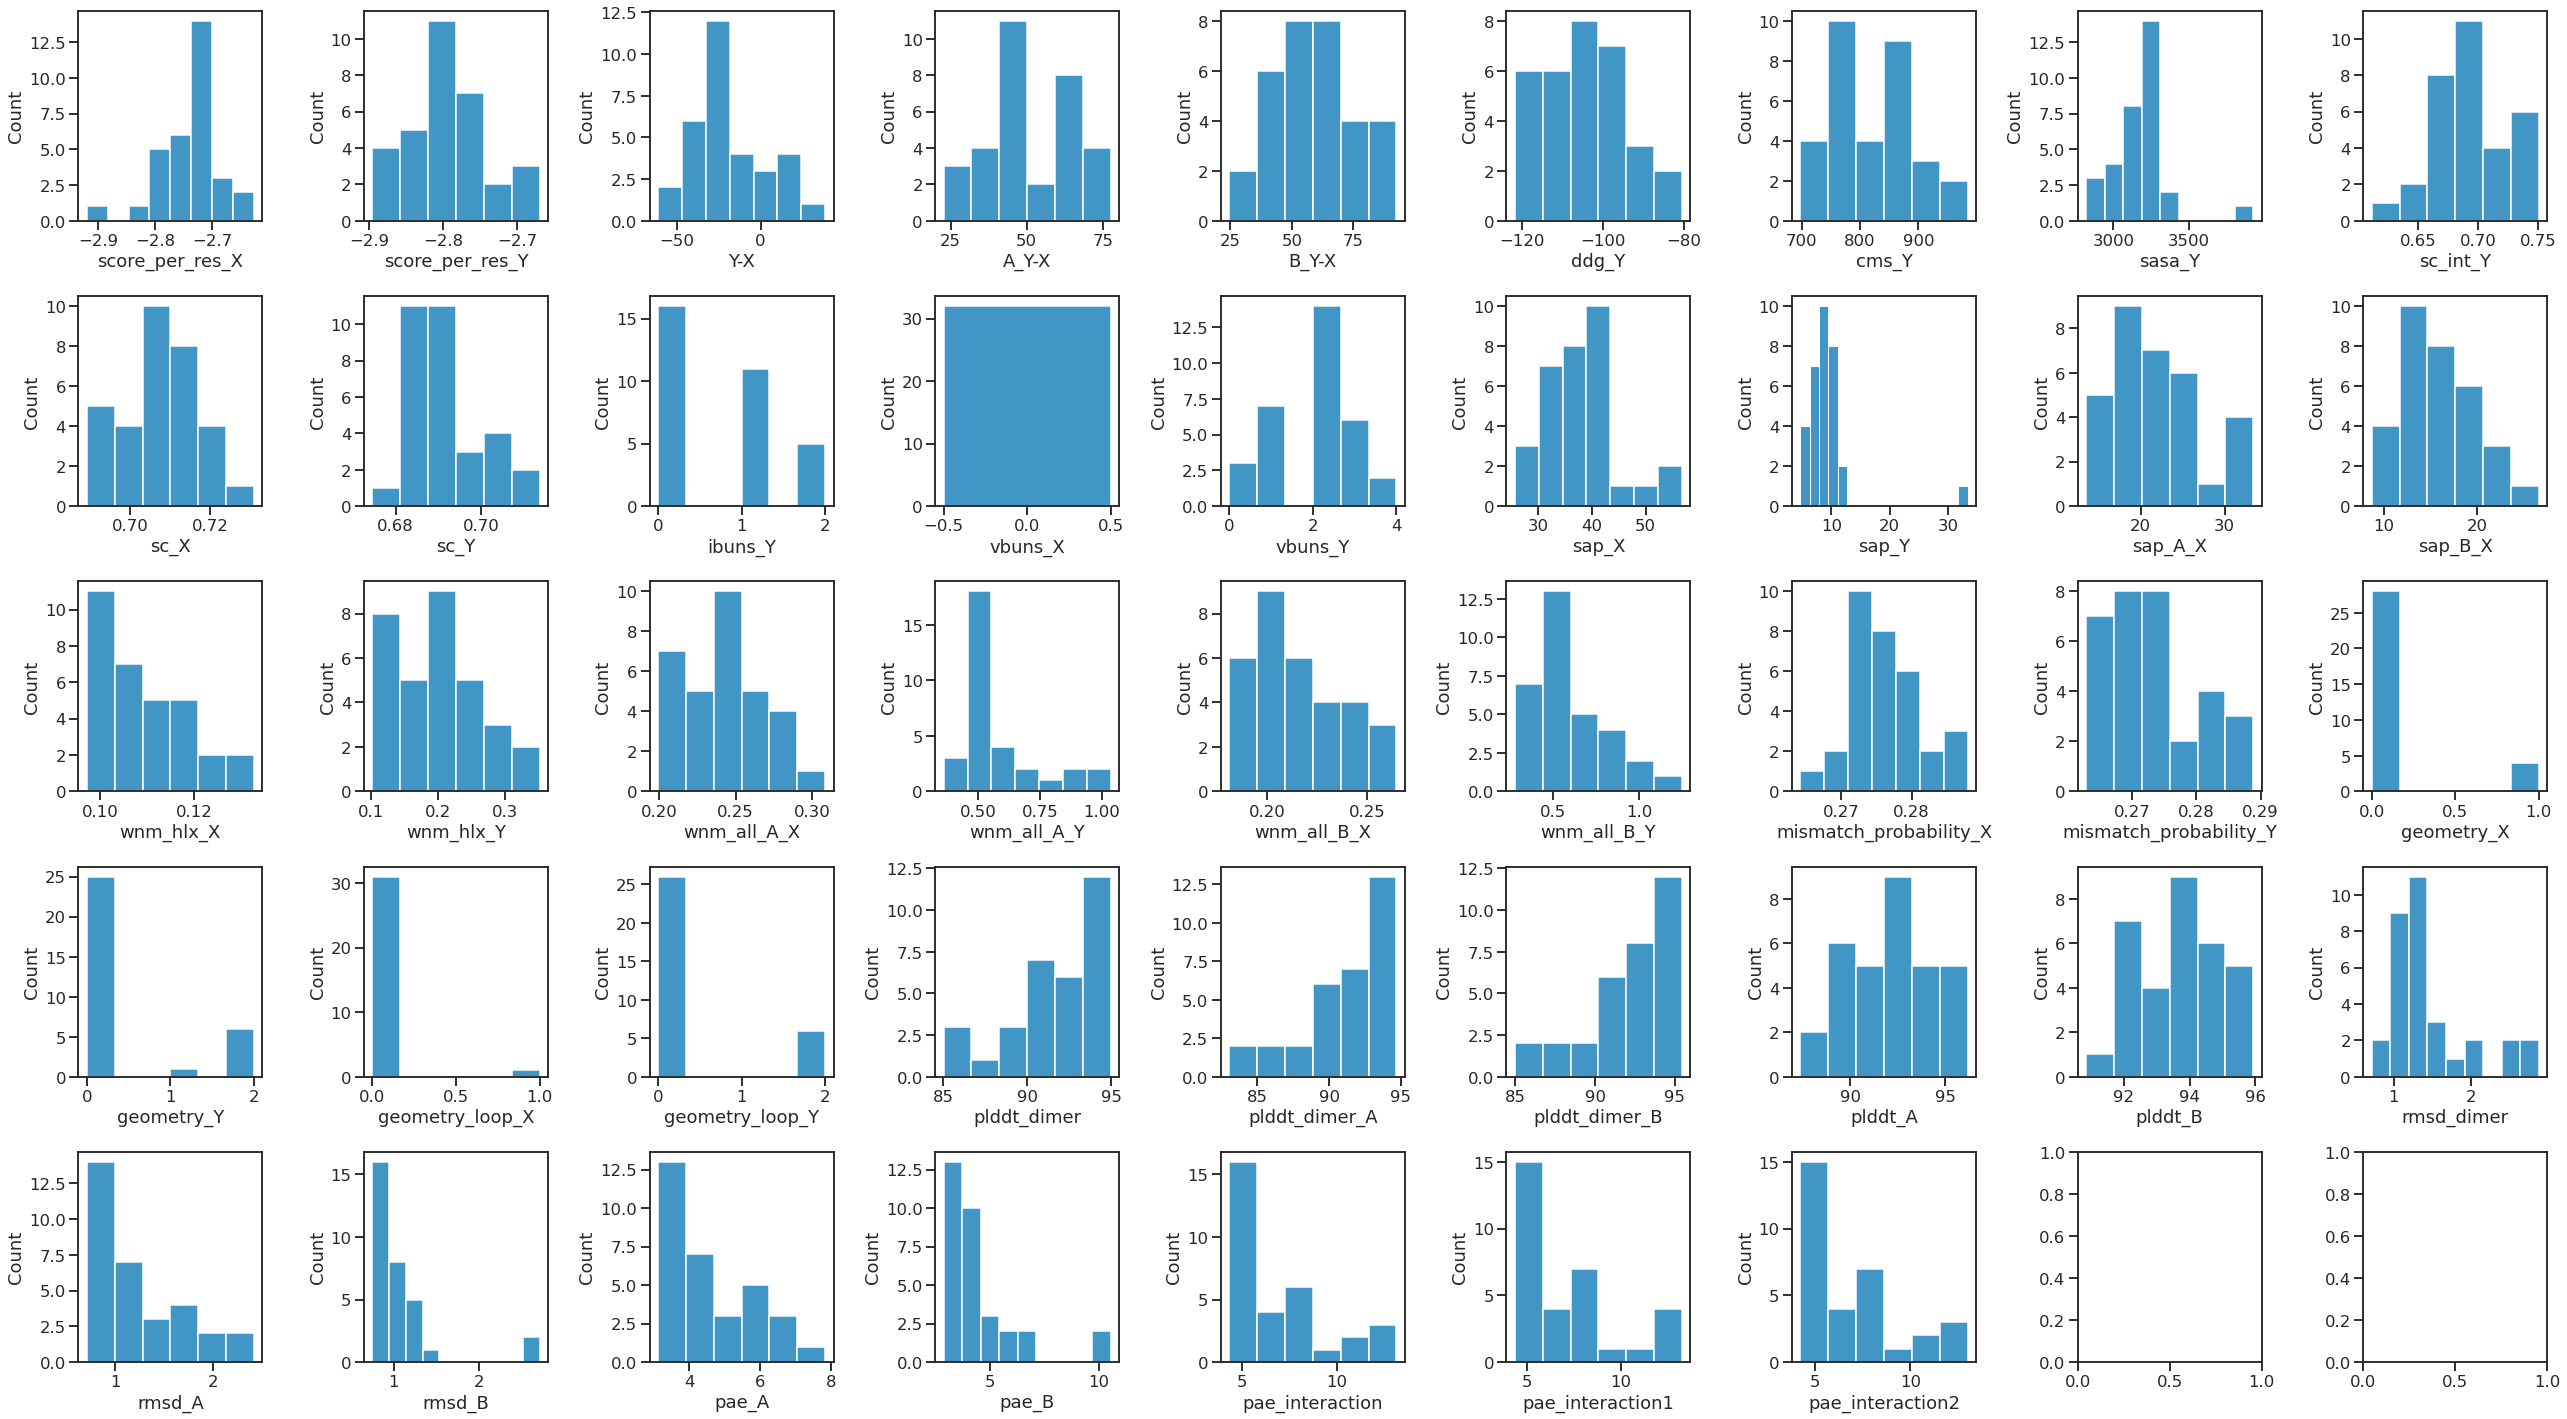

In [34]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        'plddt_dimer',
        'plddt_dimer_A',
        'plddt_dimer_B',
        'plddt_A',
        'plddt_B',
        'rmsd_dimer',
        'rmsd_A',
        'rmsd_B',
        'pae_A',
        'pae_B',
        'pae_interaction',
        'pae_interaction1',
        'pae_interaction2',
    #     "parent",
    ]

# make sure all the columns to plot are numeric
full_scores_df[cols] = full_scores_df[cols].astype(float)
histplot_df(full_scores_df, cols=cols)

# pairplot these as well

In [35]:
full_scores_df.to_json('06_alphafold_two_state/predicted_designs/full_scores_df.json')

In [22]:
# Use bb_clash to match design models to their parent one-state design

import pyrosetta.distributed.cluster as cluster

bb_clash_list = []
with open('04_alphafold_one_state/selected_af2_sample.list', 'r') as f:
    for sample_design_path in f:
        sample_design_path = sample_design_path.rstrip()
        bb_clash = float(cluster.get_scores_dict(sample_design_path)["scores"]['bb_clash'])
        bb_clash_list.append((sample_design_path, bb_clash, 'af2'))
with open('04_alphafold_one_state/selected_design_sample.list', 'r') as f:
    for sample_design_path in f:
        sample_design_path = sample_design_path.rstrip()
        bb_clash = float(cluster.get_scores_dict(sample_design_path)["scores"]['bb_clash'])
        bb_clash_list.append((sample_design_path, bb_clash, 'des'))

def get_pdb_path(bb_clash, model_str, bb_clash_list):
    for pdb_path, bb_clash_val, model_str_val in bb_clash_list:
        if abs(bb_clash_val - bb_clash) < 0.1 and model_str_val == model_str:
            return pdb_path

In [24]:
# Copy selected designs and write PyRosettaCluster-like metadata

import collections
import json
import os

for index, row in full_scores_df.iterrows():

    scores = row.to_dict()

    design_path = row.pop('design_path')
    split_design_path = design_path.split('/')
    run_str = split_design_path[1]
    decoy_dir = split_design_path[2]
    model_str = decoy_dir[:3]

    # Copy the design models with metadata

    pdb_path = get_pdb_path(scores['bb_clash'], model_str, bb_clash_list)

    pdbfile_data = json.dumps(
        {
            "instance": {"compressed": False,
                         "decoy_dir_name": decoy_dir,
                         "environment": "",
                         "output_path": "05_two_state/" + run_str,
                         "simulation_name": "05_two_state_" + run_str,
                         "simulation_records_in_scorefile": False,
                         "tasks": {"pdb_path": pdb_path,
                                   "ala_pen": 2,
                                   "met_pen": 1,
                                   "np_pen": 3},
                        },
            "metadata": {"decoy_name": index, "output_file": design_path},
            "scores": collections.OrderedDict(sorted(scores.items())),
        }
    )

    with open(design_path, 'r') as f:
        pdbstring = f.read()

    # Write full .pdb record
    pdbstring_data = pdbstring + os.linesep + "REMARK PyRosettaCluster: " + pdbfile_data
    output_file = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/06_alphafold_two_state/predicted_designs/design_models/'  + row['parent'] + '_' + index + '.pdb'
    with open(output_file, "w") as f:
        f.write(pdbstring_data)

    # Copy the AF2 models with metadata

    output_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/06_alphafold_two_state/predicted_designs'

    af_dimer_pdb_path = '06_alphafold_two_state/05_' + run_str + '_' + model_str + '/predicted_dimers/' + index + '_af2pred.pdb'
    af_monomer_a_pdb_path = '06_alphafold_two_state/05_run_23_monomers/predicted_dimers_and_monomers/' + index + '_A_af2pred.pdb'
    af_monomer_b_pdb_path = '06_alphafold_two_state/05_run_23_monomers/predicted_dimers_and_monomers/' + index + '_B_af2pred.pdb'

    for combo, path in zip(['dimer', 'monomer_A', 'monomer_B'], [af_dimer_pdb_path, af_monomer_a_pdb_path, af_monomer_b_pdb_path]):

        output_file = output_dir + '/af2_models/' + row['parent'] + '_' + index + '_' + combo + '.pdb'

        pdbfile_data = json.dumps(
            {
                "instance": {"compressed": False,
                            "decoy_dir_name": "af2_models",
                            "environment": "",
                            "output_path": output_dir,
                            "simulation_name": "06_alphafold_two_state",
                            "simulation_records_in_scorefile": False,
                            "tasks": {"pdb_path": design_path,
                                    "af_dimer_pdb_path": af_dimer_pdb_path,
                                    "af_monomer_A_pdb_path": af_monomer_a_pdb_path,
                                    "af_monomer_B_pdb_path": af_monomer_b_pdb_path},
                            },
                "metadata": {"decoy_name": index, "output_file": output_file},
                "scores": collections.OrderedDict(sorted(scores.items())),
            }
        )

        with open(path, 'r') as f:
            pdbstring = f.read()

        # Write full .pdb record
        pdbstring_data = pdbstring + os.linesep + "REMARK PyRosettaCluster: " + pdbfile_data
        with open(output_file, "w") as f:
            f.write(pdbstring_data)

    # Write the score file
        
    scorefile_data = json.dumps(
        {
            output_file: collections.OrderedDict(
                sorted(scores.items())
            ),
        }
    )
    # Write data to new scorefile
    with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/06_alphafold_two_state/predicted_designs/scores.json', "a") as f:
        f.write(scorefile_data + '\n')

In [36]:
# Are most of these coming from the same or a few inputs to two-state design? Or does it widely sample the input set?
# Answer: Yes. There are three one-state designs that, after two-state design, AF2 predicts as dimers when together and as monomers when separate.
# Solution: more broadly sample one-state designs pre-two-state design?

for index, row in full_scores_df.iterrows():

    scores = row.to_dict()

    design_path = row.pop('design_path')
    split_design_path = design_path.split('/')
    decoy_dir = split_design_path[2]
    model_str = decoy_dir[:3]

    pdb_path = get_pdb_path(scores['bb_clash'], model_str, bb_clash_list)

    print(pdb_path)

/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/0000/04_alphafold_one_state_f25dfd59393c43699579fd1d9486c08c.pdb.bz2
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/0000/04_alphafold_one_state_f25dfd59393c43699579fd1d9486c08c.pdb.bz2
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/0000/04_alphafold_one_state_f25dfd59393c43699579fd1d9486c08c.pdb.bz2
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0003/03_close_loops_9fa1fef359454e68a2531730055a1f01.pdb.bz2
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0003/03_close_loops_9fa1fef359454e68a2531730055a1f01.pdb.bz2
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0003/03_close_loops_9fa1fef359454e68a2531730055a1f01.pdb.bz2
/home/broerman/projects/crispy_shifty/projects